In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance

# Load breast cancer dataset
data = load_breast_cancer()
X = data.data
y = data.target
feature_names = data.feature_names
target_names = data.target_names

# Create DataFrame for better visualization
df = pd.DataFrame(X, columns=feature_names)
df['target'] = y

print("Dataset Shape:", X.shape)
print("\nTarget distribution:")
print(pd.Series(y).value_counts())
print("\nTarget names:", target_names)

Dataset Shape: (569, 30)

Target distribution:
1    357
0    212
Name: count, dtype: int64

Target names: ['malignant' 'benign']


In [3]:
# Preprocess the data
# Since this is originally a classification dataset, we'll use it for regression
# by predicting the probability of malignant/benign

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Training set shape:", X_train_scaled.shape)
print("Test set shape:", X_test_scaled.shape)

Training set shape: (455, 30)
Test set shape: (114, 30)


In [5]:
# Create and train AdaBoost Regressor
# Using Decision Tree as base estimator
base_estimator = DecisionTreeRegressor(max_depth=3, random_state=42)

ada_regressor = AdaBoostRegressor(
    estimator=base_estimator,
    n_estimators=100,
    learning_rate=0.1,
    random_state=42
)

# Train the model
ada_regressor.fit(X_train_scaled, y_train)

# Make predictions
y_pred = ada_regressor.predict(X_test_scaled)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("AdaBoost Regressor Performance:")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

AdaBoost Regressor Performance:
Mean Squared Error: 0.0301
Mean Absolute Error: 0.0670
R² Score: 0.8718


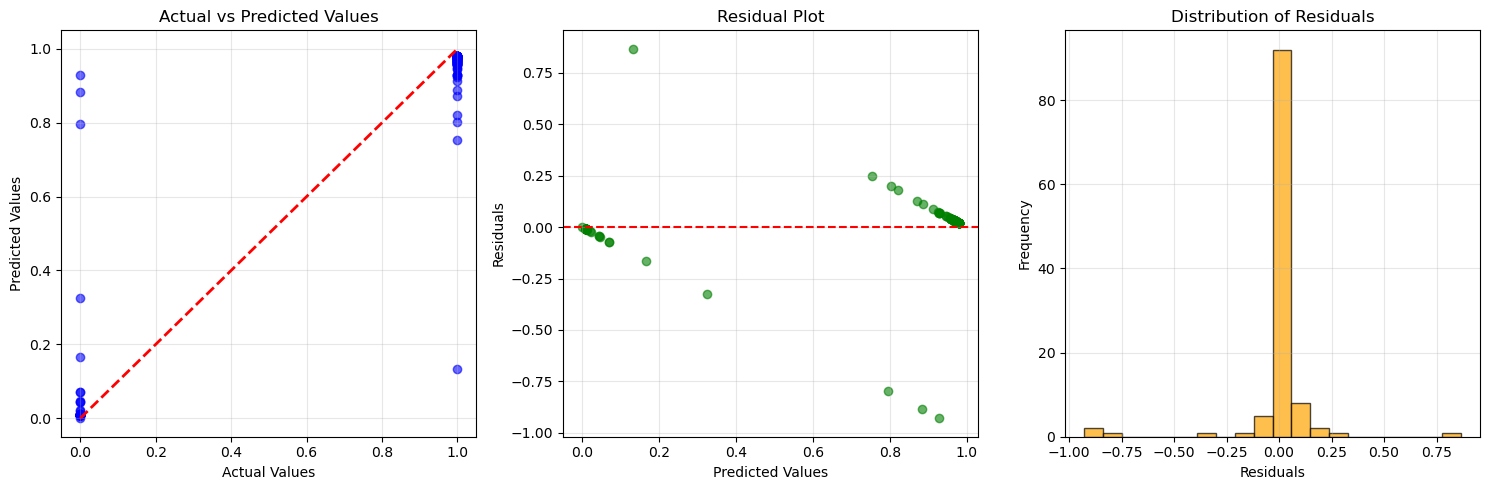

In [7]:
# Visualization 1: Actual vs Predicted Values
plt.figure(figsize=(15, 5))

# Plot 1: Actual vs Predicted scatter plot
plt.subplot(1, 3, 1)
plt.scatter(y_test, y_pred, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.grid(True, alpha=0.3)

# Plot 2: Residual plot
plt.subplot(1, 3, 2)
residuals = y_test - y_pred
plt.scatter(y_pred, residuals, alpha=0.6, color='green')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True, alpha=0.3)

# Plot 3: Distribution of residuals
plt.subplot(1, 3, 3)
plt.hist(residuals, bins=20, alpha=0.7, color='orange', edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

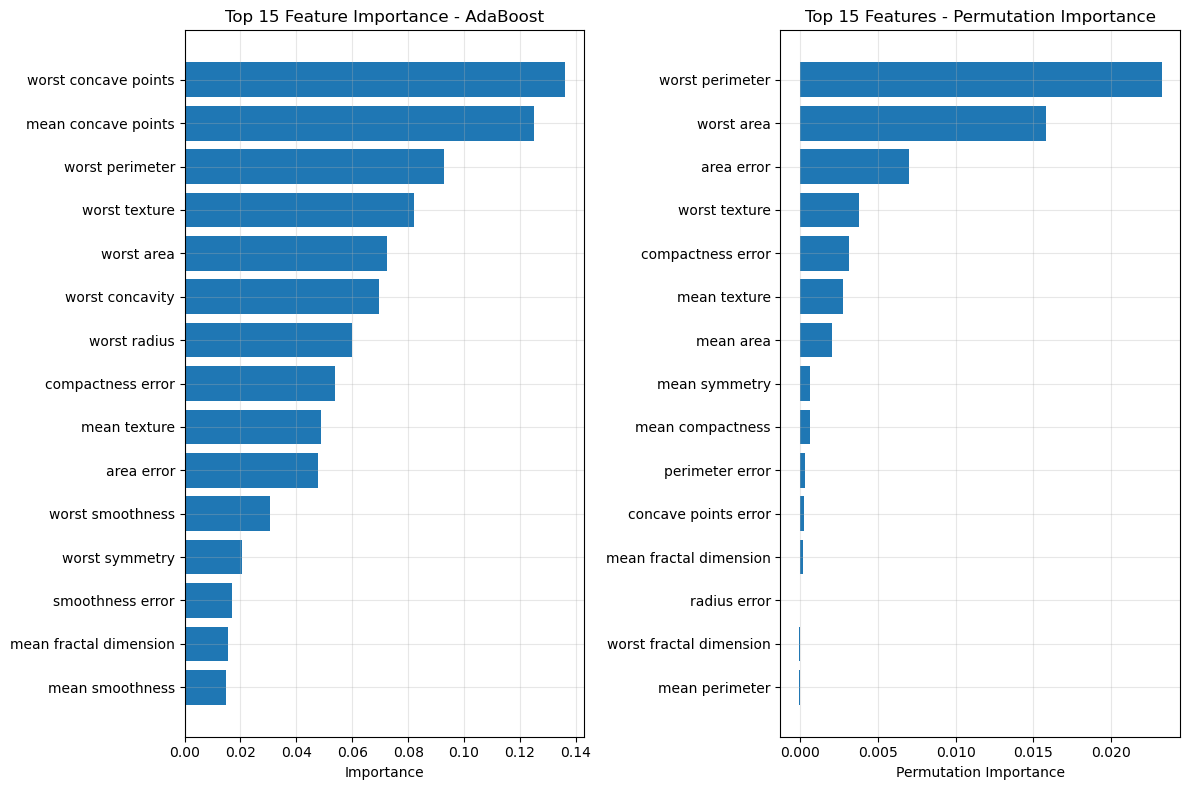

In [9]:
# Visualization 2: Feature Importance
plt.figure(figsize=(12, 8))

# Get feature importance from AdaBoost
feature_importance = ada_regressor.feature_importances_

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=True)

# Plot feature importance
plt.subplot(1, 2, 1)
plt.barh(importance_df['feature'][-15:], importance_df['importance'][-15:])
plt.xlabel('Importance')
plt.title('Top 15 Feature Importance - AdaBoost')
plt.grid(True, alpha=0.3)

# Plot 2: Permutation Importance (more reliable)
plt.subplot(1, 2, 2)
perm_importance = permutation_importance(ada_regressor, X_test_scaled, y_test, 
                                        n_repeats=10, random_state=42)
sorted_idx = perm_importance.importances_mean.argsort()

plt.barh(np.array(feature_names)[sorted_idx][-15:], 
         perm_importance.importances_mean[sorted_idx][-15:])
plt.xlabel("Permutation Importance")
plt.title("Top 15 Features - Permutation Importance")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

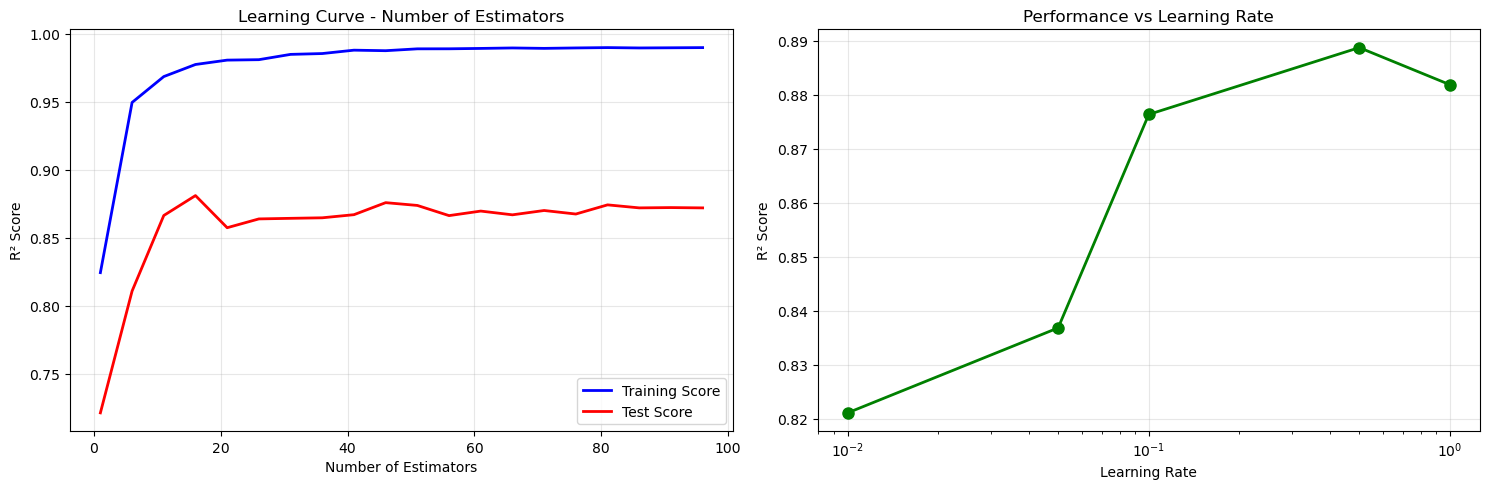

In [11]:
# Visualization 3: Learning Curve - Model performance vs number of estimators
plt.figure(figsize=(15, 5))

# Calculate training and test scores for different numbers of estimators
train_scores = []
test_scores = []
n_estimators_range = range(1, 101, 5)

for n_est in n_estimators_range:
    ada_temp = AdaBoostRegressor(
        estimator=DecisionTreeRegressor(max_depth=3),
        n_estimators=n_est,
        learning_rate=0.1,
        random_state=42
    )
    ada_temp.fit(X_train_scaled, y_train)
    
    train_score = ada_temp.score(X_train_scaled, y_train)
    test_score = ada_temp.score(X_test_scaled, y_test)
    
    train_scores.append(train_score)
    test_scores.append(test_score)

plt.subplot(1, 2, 1)
plt.plot(n_estimators_range, train_scores, 'b-', label='Training Score', linewidth=2)
plt.plot(n_estimators_range, test_scores, 'r-', label='Test Score', linewidth=2)
plt.xlabel('Number of Estimators')
plt.ylabel('R² Score')
plt.title('Learning Curve - Number of Estimators')
plt.legend()
plt.grid(True, alpha=0.3)

# Visualization 4: Performance comparison with different learning rates
learning_rates = [0.01, 0.05, 0.1, 0.5, 1.0]
learning_rate_scores = []

for lr in learning_rates:
    ada_lr = AdaBoostRegressor(
        estimator=DecisionTreeRegressor(max_depth=3),
        n_estimators=50,
        learning_rate=lr,
        random_state=42
    )
    ada_lr.fit(X_train_scaled, y_train)
    score = ada_lr.score(X_test_scaled, y_test)
    learning_rate_scores.append(score)

plt.subplot(1, 2, 2)
plt.plot(learning_rates, learning_rate_scores, 'go-', linewidth=2, markersize=8)
plt.xlabel('Learning Rate')
plt.ylabel('R² Score')
plt.title('Performance vs Learning Rate')
plt.xscale('log')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

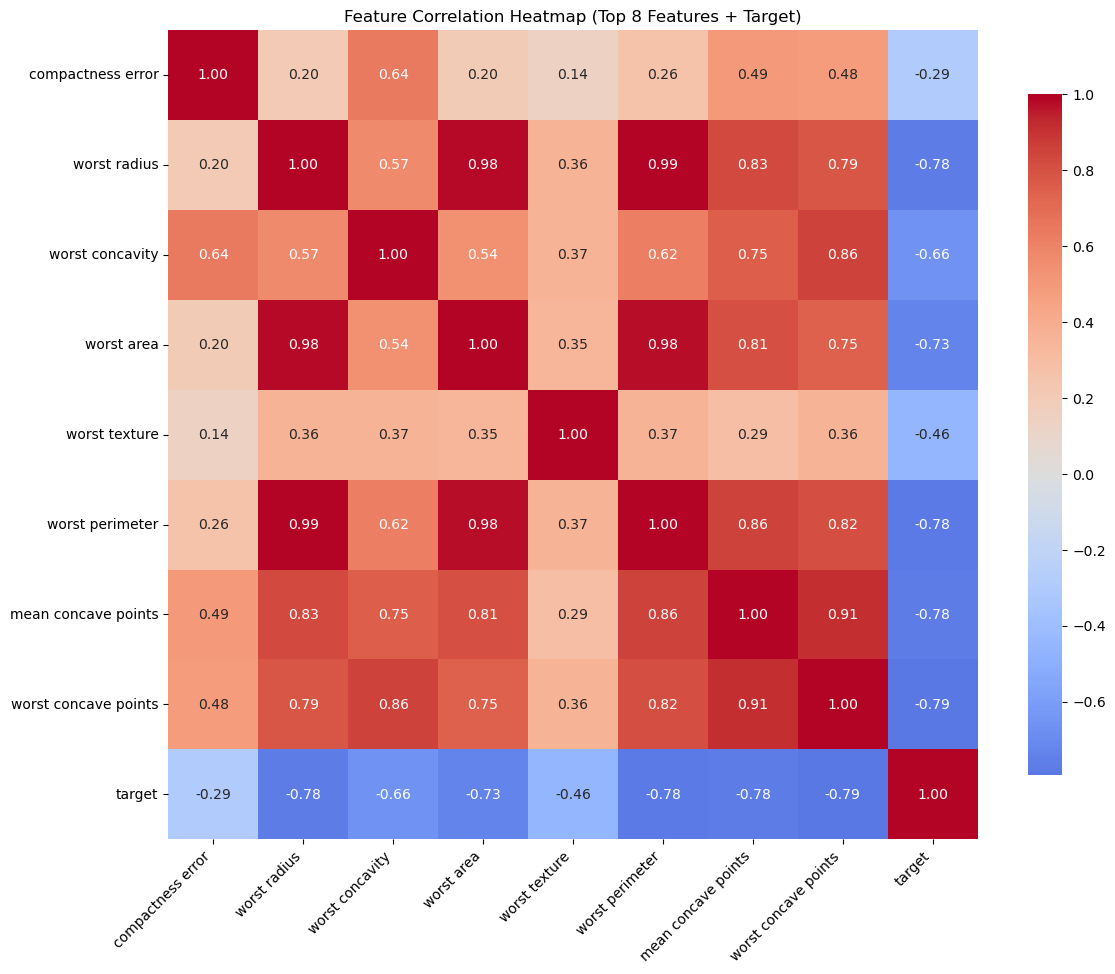

In [12]:
# Visualization 5: Most relatable visualization - Feature Relationships Heatmap
# Select top 8 most important features for better visualization
top_features_idx = feature_importance.argsort()[-8:]

# Create correlation matrix for top features
top_feature_names = feature_names[top_features_idx]
correlation_matrix = df[list(top_feature_names) + ['target']].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
plt.title('Feature Correlation Heatmap (Top 8 Features + Target)')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

<Figure size 1200x1000 with 0 Axes>

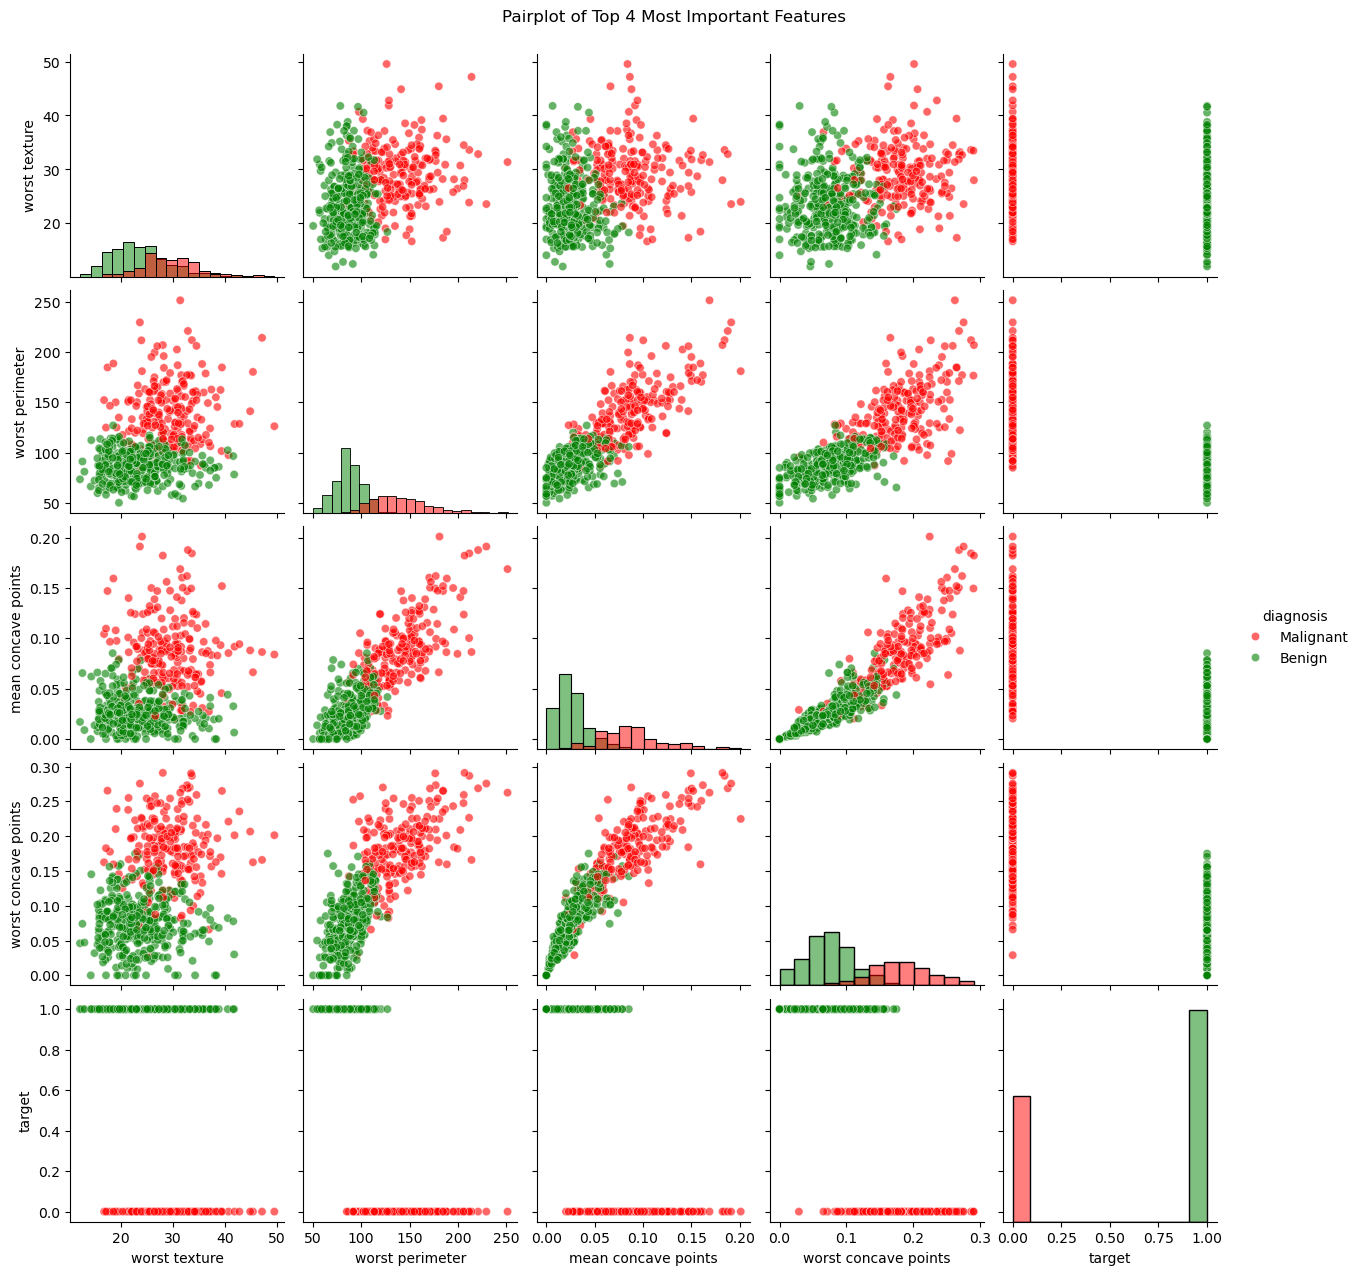

In [15]:
# Visualization 6: Pairplot of top 4 most important features (Most relatable for understanding relationships)
top_4_features = importance_df.tail(4)['feature'].values

# Create a subset DataFrame with top features and target
plot_df = df[list(top_4_features) + ['target']].copy()
plot_df['diagnosis'] = plot_df['target'].map({0: 'Malignant', 1: 'Benign'})

# Create pairplot
plt.figure(figsize=(12, 10))
sns.pairplot(plot_df, hue='diagnosis', palette={'Malignant': 'red', 'Benign': 'green'},
             diag_kind='hist', plot_kws={'alpha': 0.6})
plt.suptitle('Pairplot of Top 4 Most Important Features', y=1.02)
plt.show()

In [17]:
# Final summary and insights
print("\n" + "="*50)
print("MODEL SUMMARY AND INSIGHTS")
print("="*50)
print(f"Final R² Score: {r2:.4f}")
print(f"Best performing learning rate: {learning_rates[np.argmax(learning_rate_scores)]}")
print(f"Optimal number of estimators: ~{n_estimators_range[np.argmax(test_scores)]}")

print("\nTop 5 Most Important Features:")
for i, (feature, imp) in enumerate(importance_df.tail(5).values[::-1], 1):
    print(f"{i}. {feature}: {imp:.4f}")

print(f"\nKey Insight: The model explains {r2*100:.1f}% of variance in the target variable.")
print("Features related to worst characteristics tend to be most predictive.")


MODEL SUMMARY AND INSIGHTS
Final R² Score: 0.8718
Best performing learning rate: 0.5
Optimal number of estimators: ~16

Top 5 Most Important Features:
1. worst concave points: 0.1362
2. mean concave points: 0.1249
3. worst perimeter: 0.0927
4. worst texture: 0.0820
5. worst area: 0.0722

Key Insight: The model explains 87.2% of variance in the target variable.
Features related to worst characteristics tend to be most predictive.
